### [Nearest Neighbour Analysis](https://autogis-site.readthedocs.io/en/latest/notebooks/L3/04_nearest-neighbour.html)

- Let’s create an origin Point and a few destination Points and find out the closest destination:

In [1]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 =Point(2, 2)
dest3 = Point(0, 2.5)

- To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [2]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


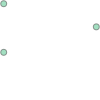

In [3]:
destinations

- Now we can find out the nearest destination point by using `nearest_points()` function:

In [4]:
nearest_geoms = nearest_points(orig, destinations)

In [5]:
type(nearest_geoms)

tuple

In [6]:
print(nearest_geoms)

(<shapely.geometry.point.Point object at 0x000001FC46B19280>, <shapely.geometry.point.Point object at 0x000001FC46825D00>)


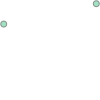

In [10]:
MultiPoint([*nearest_geoms])

In [11]:
import geopandas as gpd
import os

def read_data(path, driver=None):
    assert os.path.isfile(path), 'Input must be a valid file'
    return gpd.read_file(path) if driver is None else \
        gpd.read_file(path, driver=driver)

def read_kml(path):
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    return read_data(path, driver='KML')

In [12]:
# Define filepaths
fp1 = "data/PKS_suuralue.kml"
fp2 = "data/addresses.shp"

In [14]:
df1 = read_kml(fp1)
df2 = read_data(fp2)

In [15]:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


In [16]:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Hels...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94168 60.16996)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97835 60.18976)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


- Before calculating any distances, we should re-project the data into a projected crs.

In [17]:
df1 = df1.to_crs(epsg=3067)
df2 = df2.to_crs(epsg=3067)

- Furthermore, let’s calculate the centroids for each district area:

In [18]:
df1['centroid'] = df1.centroid
df1.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,"POLYGON Z ((376322.317 6665639.417 0.000, 3764...",POINT (375676.529 6658405.261)
1,Suur-Kauklahti,,"POLYGON Z ((367726.077 6673018.023 0.000, 3677...",POINT (365520.906 6675893.101)
2,Vanha-Espoo,,"POLYGON Z ((371207.712 6677289.881 0.000, 3711...",POINT (367400.175 6681941.088)
3,Pohjois-Espoo,,"POLYGON Z ((376528.523 6683480.345 0.000, 3766...",POINT (372191.037 6687785.458)
4,Suur-Matinkylä,,"POLYGON Z ((375347.271 6672052.630 0.000, 3753...",POINT (375678.189 6670243.076)


- we want to apply the Shapely nearest_pointsfunction so that we compare each polygon centroid to all address points

In [23]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column='geometry'):
    # create union(multipoint) of other GeoDataFrame 
    other_points = other_gdf['geometry'].unary_union
    # find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    # get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf['geometry'] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    return nearest_value

- Let’s check how unary union works by applying it to the address points GeoDataFrame:

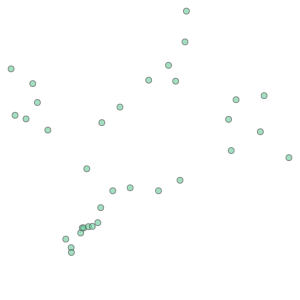

In [24]:
unary_union = df2.unary_union
unary_union

- Try first applying the function without any additional modifications:

In [25]:
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", axis=1)

In [26]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON Z ((376322.317 6665639.417 0.000, 3764...",POINT (375676.529 6658405.261),POINT (384632.9367817009 6670672.153797519)
1,Suur-Kauklahti,,"POLYGON Z ((367726.077 6673018.023 0.000, 3677...",POINT (365520.906 6675893.101),POINT (381505.3519674061 6678285.881515038)
2,Vanha-Espoo,,"POLYGON Z ((371207.712 6677289.881 0.000, 3711...",POINT (367400.175 6681941.088),POINT (381286.7694219984 6680863.79179517)
3,Pohjois-Espoo,,"POLYGON Z ((376528.523 6683480.345 0.000, 3766...",POINT (372191.037 6687785.458),POINT (381286.7694219984 6680863.79179517)
4,Suur-Matinkylä,,"POLYGON Z ((375347.271 6672052.630 0.000, 3753...",POINT (375678.189 6670243.076),POINT (384320.8982796484 6671412.394772961)


- we can also get the id of points closest to each district

In [28]:
df1["nearest_loc_id"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", value_column='id', axis=1)

In [29]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc,nearest_loc_id
0,Suur-Espoonlahti,,"POLYGON Z ((376322.317 6665639.417 0.000, 3764...",POINT (375676.529 6658405.261),POINT (384632.9367817009 6670672.153797519),1005
1,Suur-Kauklahti,,"POLYGON Z ((367726.077 6673018.023 0.000, 3677...",POINT (365520.906 6675893.101),POINT (381505.3519674061 6678285.881515038),1020
2,Vanha-Espoo,,"POLYGON Z ((371207.712 6677289.881 0.000, 3711...",POINT (367400.175 6681941.088),POINT (381286.7694219984 6680863.79179517),1017
3,Pohjois-Espoo,,"POLYGON Z ((376528.523 6683480.345 0.000, 3766...",POINT (372191.037 6687785.458),POINT (381286.7694219984 6680863.79179517),1017
4,Suur-Matinkylä,,"POLYGON Z ((375347.271 6672052.630 0.000, 3753...",POINT (375678.189 6670243.076),POINT (384320.8982796484 6671412.394772961),1000
